### 1. 정확도(Accuracy)
- 모델에 따라 단순한 알고리즘 예측으로도 정확도가 높게 나올 수 있다.
- 불균형한 레이블 값 분포에서 성능을 판단할 경우, 적합한 평가 지표가 아니다.
<br>->분류의 경우 적합한 평가 방식이 아닐 수 있다.

In [1]:
from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self,X):
      pred=np.zeros((X.shape[0],1))
      for i in range (X.shape[0]):
        if X['Sex'].iloc[i]==1:
          pred[i]=0
        else:
          pred[i]=1

      return pred

In [2]:
## 전처리 함수 정리
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df
def format_features(df):
    df['Cabin']=titanic_df['Cabin'].str[:1]
    features=['Cabin','Sex','Embarked']
    for feature in features:
        le=LabelEncoder()
        le=le.fit(df[feature])
        df[feature]=le.transform(df[feature])
    return df

def transform_features(df):
    df=fillna(df)
    df=drop_features(df)
    df=format_features(df)
    return df

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df=pd.read_csv('titanic_train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived',axis=1)
X_titanic_df=transform_features(X_titanic_df)

X_train,X_test,y_train,y_test=train_test_split(X_titanic_df,y_titanic_df,test_size=0.2,random_state=0)

In [5]:
myclf=MyDummyClassifier()
myclf.fit(X_train,y_train)

mypredictions=myclf.predict(X_test)
print(accuracy_score(y_test,mypredictions))

0.7877094972067039


In [6]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [7]:
digits=load_digits()
y=(digits.target==7).astype(int)
X_train,X_test,y_train,y_test=train_test_split(digits.data,y,random_state=11)

In [8]:
fakeclf=MyFakeClassifier()
fakeclf.fit(X_train,y_train)
fakepred=fakeclf.predict(X_test)
print(accuracy_score(y_test,fakepred))

0.9


### 2. 오차 행렬
- 학습된 분류 모델이 예측을 수행하며 얼마나 헷갈리고 있는지 함께 보여주는 지표
- TN,FP, FN,TP 형태로 오차 행렬의 4분면을 채운다.

In [9]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,fakepred)

array([[405,   0],
       [ 45,   0]])

### 3. 정밀도와 재현율
- 정밀도: TP/(FP+TP)
- 재현율: TP/(FN+TP)

In [50]:
#평가를 한번에 호출하는 함수
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix

#ROC-AUC 추가
def get_clf_eval(y_test,pred, pred_proba):
  confusion=confusion_matrix(y_test,pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred)
  f1=f1_score(y_test,pred)
  recall=recall_score(y_test,pred)
  roc_auc=roc_auc_score( y_test, pred_proba)
  print('오차행렬')
  print(confusion)
  print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy,precision,recall, f1, roc_auc))

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df=pd.read_csv('titanic_train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived',axis=1)
X_titanic_df=transform_features(X_titanic_df)

X_train,X_test,y_train,y_test=train_test_split(X_titanic_df,y_titanic_df,test_size=0.2,random_state=11)

lr_clf=LogisticRegression(solver='liblinear')
lr_clf.fit(X_train,y_train)
pred=lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705


- 정밀도/재현율 트레이드오프: 정밀도와 재현율중 어느하나를 강제로 높이면 다른하나가 떨어지는 현상

In [12]:
pred_proba=lr_clf.predict_proba(X_test)
pred=lr_clf.predict(X_test)
print('pred_proba()결과 shape:{0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 추출:\n',pred_proba[:3])
print(pred[:3])

pred_proba()결과 shape:(179, 2)
pred_proba array에서 앞 3개만 추출:
 [[0.44890748 0.55109252]
 [0.86309497 0.13690503]
 [0.86409996 0.13590004]]
[1 0 0]


In [13]:
from sklearn.preprocessing import Binarizer

custom_threshold=0.5

pred_proba_1=pred_proba[:,1].reshape(-1,1)
bianarizers=Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict=bianarizers.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict)

오차행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705


In [14]:
from sklearn.preprocessing import Binarizer

custom_threshold=0.4

pred_proba_1=pred_proba[:,1].reshape(-1,1)
bianarizers=Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict=bianarizers.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict)

오차행렬
[[97 21]
 [11 50]]
정확도:0.8212, 정밀도:0.7042, 재현율:0.8197


### 4. f1 스코어
- 정밀도와 재현율이 어느 한쪽으로 치우치지 않은 수치를 나타낼 때 상대적으로 높은 값을 가진다.
- f1=2*((precision*recall)/(precision+recall))

In [15]:
from sklearn.metrics import f1_score
f1=f1_score(y_test,pred)
print(f1)

0.7966101694915254


### 5. ROC 곡선과 AUC


### 6. 피마 인디언 당뇨병 예측

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [18]:
diabetes_data=pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [19]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [27]:
X=diabetes_data.iloc[:,:-1]
y=diabetes_data.iloc[:,-1]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=156, stratify=y)

#로지스틱 회귀로 학습, 예측 및 평가 수행

lr_clf=LogisticRegression(solver='liblinear')
lr_clf.fit(X_train,y_train)
pred=lr_clf.predict(X_test)
pred_proba=lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred,pred_proba)

오차행렬
[[87 13]
 [22 32]]
정확도:0.7727, 정밀도:0.7111, 재현율:0.5926, F1: 0.6465, AUC:0.8083


In [34]:
pred_proba_c1=lr_clf.predict_proba(X_test)[:,1]
precisions, recalls, thresholds=precision_recall_curve(y_test,pred_proba_c1)
thr_index=np.arange(0,thresholds.shape[0],15)
print(thr_index)
print('10개 임계값:', np.round(thresholds[thr_index], 2))
print('정밀도:', np.round(precisions[thr_index], 3))
print('재현율:', np.round(recalls[thr_index], 3))

[  0  15  30  45  60  75  90 105 120 135 150]
10개 임계값: [0.02 0.09 0.14 0.18 0.23 0.3  0.35 0.47 0.59 0.72 0.83]
정밀도: [0.351 0.367 0.403 0.459 0.5   0.544 0.609 0.694 0.794 0.895 0.75 ]
재현율: [1.    0.944 0.926 0.926 0.87  0.796 0.722 0.63  0.5   0.315 0.056]


In [35]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


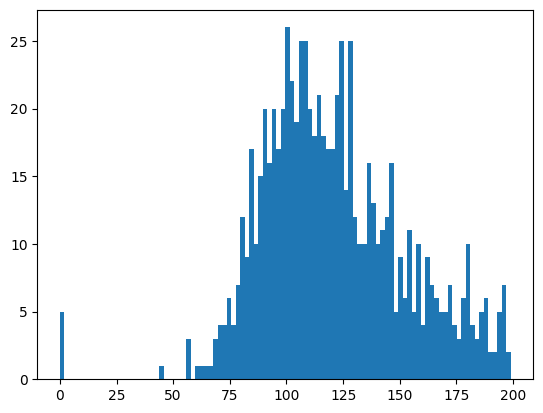

In [37]:
plt.hist(diabetes_data['Glucose'],bins=100)
plt.show()#포도당 수치에 0이 들어가 있는 것을 확인할 수 있고 말이 안되는 수치이다.

In [38]:
#min()값이 0인게 전체 데이터 건수 대비 몇퍼센트 존재하는지 알아보자
zero_features=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

total_count=diabetes_data['Glucose'].count()

for feature in zero_features:
  zero_count=diabetes_data[diabetes_data[feature]==0][feature].count()
  print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f}%'.format(feature,zero_count,100*zero_count/total_count))
  #0이 상당히 많은 것을 확인할 수 있으나 일괄적으로 삭제할 경우 학습에 효과적이지 못하기 때문에 0값을 평균으로 대체하자.

Glucose 0 건수는 5, 퍼센트는 0.65%
BloodPressure 0 건수는 35, 퍼센트는 4.56%
SkinThickness 0 건수는 227, 퍼센트는 29.56%
Insulin 0 건수는 374, 퍼센트는 48.70%
BMI 0 건수는 11, 퍼센트는 1.43%


In [39]:
mean_zero_features=diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0,mean_zero_features)

In [56]:
X=diabetes_data.iloc[:,:-1]
y=diabetes_data.iloc[:,-1]

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=156, stratify=y)

#로지스틱 회귀로 학습, 예측 및 평가 수행

lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
pred=lr_clf.predict(X_test)
pred_proba=lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred,pred_proba)

오차행렬
[[90 10]
 [21 33]]
정확도:0.7987, 정밀도:0.7674, 재현율:0.6111, F1: 0.6804, AUC:0.8433


In [58]:
#임계값에 따른 평가 수치를 출력해보니 0.48정도의 임계값이 적당할 것으로 예상된다.
# 임계값을 0.48로 낮춘 후 다시 적용을 해보면.(predict 메서드는 임계값을 마음대로 변환 할 수없어 binarizer을 사용한다.)
pred_proba=lr_clf.predict_proba(X_test)
binarizer=Binarizer(threshold=0.48)
pred_th_048=binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차행렬
[[88 12]
 [19 35]]
정확도:0.7987, 정밀도:0.7447, 재현율:0.6481, F1: 0.6931, AUC:0.8433
